In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from abc import ABC, abstractmethod
import torch.nn as nn
from typing import Tuple


def generate_trajectories(
    sampling_method: str,
    bounds: tuple,
    time_span: torch.Tensor,
    dt: float,
    num_points: int,
    kernel_fn=None,
    system=None,
    predefined_initial_conditions=None
):
    """
    Generates trajectories using the given sampling method and kernel function, or uses predefined initial conditions.

    :param sampling_method: Method for sampling initial conditions ('random', 'grid', 'density').
    :param bounds: Tuple (max_x, max_y) to define the bounds of sampling space.
    :param time_span: Time span for integration as a tensor [t_start, t_end].
    :param dt: Time step for integration.
    :param num_points: Number of initial points to sample.
    :param kernel_fn: Kernel function used to determine the density of sampling (if 'density' sampling is used).
    :param system: Dynamical system (LimitCycle or VanDerPol).
    :param predefined_initial_conditions: Predefined list of initial conditions for trajectories.
    :return: Time values, trajectories, and sampled initial conditions.
    """
    # Bounds for random sampling
    max_x, max_y = bounds

    #check for consistency of initial conditions and sampling_method?

    # Handle predefined initial conditions if provided
    if predefined_initial_conditions is not None:
        # Ensure predefined initial conditions are in tensor format
        initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)
        num_points = len(initial_conditions)  # Update num_points to match predefined conditions
    else:
        initial_conditions = []
        # Sample initial points based on the chosen method
        if sampling_method == 'uniform':
            # Sample random points uniformly within the bounds
            for _ in range(num_points):
                x = np.random.uniform(-max_x, max_x)
                y = np.random.uniform(-max_y, max_y)
                initial_conditions.append([x, y])

        elif sampling_method == 'grid':
            # Sample points on a grid
            x_vals = np.linspace(-max_x, max_x, num_points)
            y_vals = np.linspace(-max_y, max_y, num_points)
            for x in x_vals:
                for y in y_vals:
                    initial_conditions.append([x, y])

        elif sampling_method == 'density' and kernel_fn is not None:
            # Sample based on a custom probability density (using a given kernel function)
            points = []
            weights = []
            for _ in range(num_points):
                x = np.random.uniform(-max_x, max_x)
                y = np.random.uniform(-max_y, max_y)
                point = torch.tensor([x, y], dtype=torch.float32)
                weight = kernel_fn(point)  # Use the kernel function directly
                points.append(point)
                weights.append(weight)

            # Normalize the weights so they sum to 1
            weights = torch.tensor(weights)
            weights = weights / torch.sum(weights)

            # Sample initial points based on the kernel weights
            indices = torch.multinomial(weights, num_samples=num_points, replacement=True)
            initial_conditions = [points[i].numpy() for i in indices]

        # Convert initial conditions to a numpy array and then to a tensor
        initial_conditions = torch.tensor(np.array(initial_conditions), dtype=torch.float32)

    # Time points for integration
    t_values = torch.arange(time_span[0], time_span[1], dt)

    # Integrate the system for each initial condition
    trajectories = []
    for initial_condition in initial_conditions:
        trajectory = odeint(system, initial_condition, t_values, method='rk4')
        trajectories.append(trajectory)

    return t_values, trajectories, initial_conditions


In [250]:
import torch
import torch.nn as nn
from typing import Callable, Tuple


class DynamicalSystem(nn.Module):
    """
    Base class for a dynamical system. 
    Any subclass should implement the `forward` method defining dx/dt = f(t, x).
    """

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the time derivative dx/dt.
        
        :param t: Scalar tensor representing time.
        :param x: Tensor representing the system state, shape (batch_size, state_dim).
        :return: Tensor of shape (batch_size, state_dim) representing dx/dt.
        """
        raise NotImplementedError("Subclasses must implement the forward method.")

    
class LimitCycle(DynamicalSystem):
    """
    A simple limit cycle system with dynamics defined in polar coordinates.
    """

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Ensure batch dimension
        
        x_val, y_val = x[:, 0], x[:, 1]
        r = torch.sqrt(x_val**2 + y_val**2)
        theta = torch.atan2(y_val, x_val)
        
        dx_dt = -r * ((r - 1) * torch.cos(theta) - torch.sin(theta))
        dy_dt = -r * ((r - 1) * torch.sin(theta) + torch.cos(theta))
        
        return torch.stack([dx_dt, dy_dt], dim=1)
    

class RingAttractor(DynamicalSystem):
    """
    A simple ring attractor system with dynamics defined in polar coordinates.
    """

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Ensure batch dimension
        
        x_val, y_val = x[:, 0], x[:, 1]
        r = torch.sqrt(x_val**2 + y_val**2)
        theta = torch.atan2(y_val, x_val)
        
        dx_dt = -r * ((r - 1) * torch.cos(theta))
        dy_dt = -r * ((r - 1) * torch.sin(theta))
        
        return torch.stack([dx_dt, dy_dt], dim=1)

# Van der Pol oscillator as an example target system
class VanDerPol(DynamicalSystem):
    def __init__(self, mu: float = 1.0) -> None:
        super().__init__()
        self.mu = mu

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # Ensure that x is a 2D tensor, even if batch_size = 1
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Add a batch dimension if it's missing

        dxdt = torch.zeros_like(x)
        dxdt[:, 0] = x[:, 1]
        dxdt[:, 1] = self.mu * (1 - x[:, 0] ** 2) * x[:, 1] - x[:, 0]
        return dxdt

class LinearSystem(DynamicalSystem):
    """
    A linear dynamical system of the form dx/dt = Ax.
    """

    def __init__(self, A: torch.Tensor):
        """
        :param A: Square matrix defining the linear system.
        """
        super().__init__()
        self.A = A

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return torch.matmul(x, self.A.T)  # Ensure correct matrix multiplication


class NonlinearSystem(DynamicalSystem):
    """
    A general nonlinear system where the dynamics are defined by an arbitrary function.
    """

    def __init__(self, f: Callable[[torch.Tensor, torch.Tensor], torch.Tensor]):
        """
        :param f: Function that computes dx/dt given (t, x).
        """
        super().__init__()
        self.f = f

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.f(t, x)


class TransformedSystem(DynamicalSystem):
    """
    A transformed dynamical system where the inverse of a diffeomorphism is applied to the state before computing dynamics 
    (and then the diffeomorphism to the trajectories)
    """
    def __init__(self, base_system: nn.Module, diffeomorphism_network: nn.Module) -> None:
        super().__init__()
        self.base_system = base_system
        self.diffeomorphism_network = diffeomorphism_network

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Ensure x is at least (1, dim)

        transformed_x = self.diffeomorphism_network.inverse(x)
        dx_dt_transformed = self.base_system(t, transformed_x)
        dx_dt_transformed = self.diffeomorphism_network(dx_dt_transformed)
        return dx_dt_transformed.squeeze(0)  # Restore original shape if needed

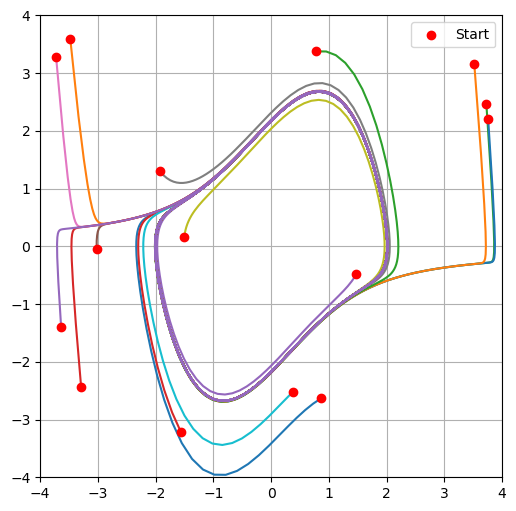

In [152]:

# Kernel function based on the distance from the unit circle
def unit_circle_kernel(x: torch.Tensor) -> torch.Tensor:
    r = torch.sqrt(x[0]**2 + x[1]**2)  # Calculate radial distance
    distance_from_unit_circle = torch.abs(r - 1)  # Distance from unit circle
    return torch.exp(-0.5 * (distance_from_unit_circle**2))  # Default sigma = 1

# Wrapper function to create a kernel function with a fixed sigma
def create_kernel_with_sigma(sigma: float):
    """
    Returns a kernel function with a fixed sigma value for sampling.
    """
    def kernel_with_sigma(x: torch.Tensor) -> torch.Tensor:
        r = torch.sqrt(x[0]**2 + x[1]**2)  # Calculate radial distance
        distance_from_unit_circle = torch.abs(r - 1)  # Distance from unit circle
        return torch.exp(-0.5 * (distance_from_unit_circle**2) / sigma**2)  # Apply custom sigma
    return kernel_with_sigma


# Define parameters
bounds = (4.0, 4.0)  # Bounds for sampling
time_span = torch.tensor([0.0, 10.0])  # Time span
dt = 0.05  # Time step
num_points = 15  # Number of points to sample
sigma_value = 0.2  # Custom sigma for the kernel function
# Create the kernel function with the custom sigma
kernel_with_sigma = create_kernel_with_sigma(sigma_value)

# Generate the trajectories with density-based sampling using the kernel function with sigma
# Example of using 'density' sampling method with the new function
t_values, trajectories, initial_conditions = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    bounds=bounds,                 # Define the bounds for initial conditions
    time_span=torch.tensor([0.0, 50.0]), # Time span for trajectory generation
    dt=0.05,                           # Time step
    num_points=num_points,                     # Number of initial points to sample
    kernel_fn=kernel_with_sigma,       # The kernel function for density-based sampling
    system=VanDerPol(mu=1.0)           # The target system, e.g., VanDerPol system
)


# Plot the trajectories
fig, ax = plt.subplots(figsize=(6, 6))
for traj in trajectories:
    ax.plot(traj[:, 0].numpy(), traj[:, 1].numpy())

ax.scatter(initial_conditions[:, 0].numpy(), initial_conditions[:, 1].numpy(), color='r', label='Start', zorder=5)

# Ensure equal scaling for both axes
ax.set_xlim([-bounds[0], bounds[0]])
ax.set_ylim([-bounds[1], bounds[1]])

ax.set_aspect('equal', 'box')
ax.grid(True)
ax.legend()
plt.show()


# scipy

In [125]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import solve_ivp

# # Kernel function based on the distance from the unit circle
# def unit_circle_kernel(x: np.ndarray) -> np.ndarray:
#     r = np.sqrt(x[0]**2 + x[1]**2)  # Calculate radial distance
#     distance_from_unit_circle = np.abs(r - 1)  # Distance from unit circle
#     return np.exp(-0.5 * (distance_from_unit_circle**2))  # Default sigma = 1

# # Wrapper function to create a kernel function with a fixed sigma
# def create_kernel_with_sigma(sigma: float):
#     """
#     Returns a kernel function with a fixed sigma value for sampling.
#     """
#     def kernel_with_sigma(x: np.ndarray) -> np.ndarray:
#         r = np.sqrt(x[0]**2 + x[1]**2)  # Calculate radial distance
#         distance_from_unit_circle = np.abs(r - 1)  # Distance from unit circle
#         return np.exp(-0.5 * (distance_from_unit_circle**2) / sigma**2)  # Apply custom sigma
#     return kernel_with_sigma

# # Define the dynamical system
# def limit_cycle_system(t, x):
#     """
#     Defines the system of differential equations for the limit cycle.
#     """
#     x_val, y_val = x
#     r = np.sqrt(x_val**2 + y_val**2)
#     theta = np.arctan2(y_val, x_val)

#     dx_dt = -r * ((r - 1) * np.cos(theta) - np.sin(theta))
#     dy_dt = -r * ((r - 1) * np.sin(theta) + np.cos(theta))

#     return [dx_dt, dy_dt]


# # Define parameters
# bounds = (2.0, 2.0)  # Bounds for sampling
# time_span = (0.0, 50.0)  # Time span
# dt = 0.05  # Time step
# num_points = 50  # Number of points to sample
# sigma_value = 0.5  # Custom sigma for the kernel function

# # Create the kernel function with the custom sigma
# kernel_with_sigma = create_kernel_with_sigma(sigma_value)

# # Generate the trajectories with density-based sampling using the kernel function with sigma
# t_values, trajectories, initial_conditions = generate_trajectories(
#     'density', bounds, time_span, dt, num_points, kernel_fn=kernel_with_sigma)

# # Plot the trajectories
# fig, ax = plt.subplots(figsize=(6, 6))
# for traj in trajectories:
#     ax.plot(traj[:, 0], traj[:, 1])

# ax.scatter(initial_conditions[:, 0], initial_conditions[:, 1], color='r', label='Start', zorder=5)

# # Ensure equal scaling for both axes
# ax.set_xlim([-bounds[0], bounds[0]])
# ax.set_ylim([-bounds[1], bounds[1]])

# ax.set_aspect('equal', 'box')
# ax.grid(True)
# ax.legend()
# plt.show()


In [248]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior in CNNs
    torch.backends.cudnn.benchmark = False  # May slow down training but ensures reproducibility


class PeriodicActivation(nn.Module):
    """Implements a periodic activation function."""
    def __init__(self, function: str = "sin"):
        super().__init__()
        if function == "sin":
            self.func = torch.sin
        elif function == "cos":
            self.func = torch.cos
        else:
            raise ValueError(f"Unsupported periodic activation: {function}. Choose 'sin' or 'cos'.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.func(x)

class DiffeomorphismNetwork(nn.Module):
    """Represents a diffeomorphic transformation close to the identity.
    Can be initialized as a perturbation-based transformation with a fixed normalization.
    """
    def __init__(self, dim: int, hidden_dim: int = 64, activation: str = "tanh", epsilon: float = None, grid_size: int = 10, grid_bound: float = 1) -> None:
        """
        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden layer size.
            activation (str): Activation function ('tanh' or 'relu').
            epsilon (float, optional): If set, the transformation is scaled to this magnitude.
            grid_size (int): Number of points to use for computing normalization if epsilon is set.
        """
        super().__init__()
        activation_fn = self._get_activation(activation)
        self.activation_fn = activation_fn
        self.layers = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, dim)
        )
        self.epsilon = epsilon
        self.normalization_factor = None

        if epsilon is not None:
            self._compute_normalization(dim, grid_size, grid_bound)

    def _get_activation(self, activation: str) -> nn.Module:
        """Returns the corresponding activation function."""
        activations = {
            "tanh": nn.Tanh(),
            "relu": nn.ReLU(),
            "leaky_relu": nn.LeakyReLU(),
            "gelu": nn.GELU(),
            "elu": nn.ELU(),
            "silu": nn.SiLU(),  # Also known as Swish
            "sin": PeriodicActivation("sin"),
            "cos": PeriodicActivation("cos"),
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation function: {activation}. Choose from {list(activations.keys())}.")
        return activations[activation]

    def _compute_normalization(self, dim: int, grid_points: int, grid_bound: float) -> None:
        """Precompute the normalization factor based on a structured grid of points."""
        with torch.no_grad():
            # Generate an evenly spaced grid in each dimension
            linspace = torch.linspace(-grid_bound, grid_bound, grid_points)
            grid = torch.tensor(list(itertools.product(*[linspace] * dim)))  # Cartesian product to form the grid

            Hx = self.layers(grid)
            self.normalization_factor = torch.max(Hx).item()  # Compute the maximum norm over the grid
            # norm_Hx = torch.norm(Hx, dim=1, keepdim=True)
            # mean_norm = norm_Hx.mean()  # Compute average norm over the grid
            # self.normalization_factor = mean_norm.clamp(min=1e-6).item()  # Avoid division by zero

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        Hx = self.layers(x)

        if self.epsilon is not None and self.normalization_factor is not None:
            Hx = (Hx / self.normalization_factor) * self.epsilon

            return x + Hx
        else:
            return Hx

    def inverse(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        """Approximate inverse using fixed-point iteration."""
        y = x.clone()
        for _ in range(steps):
            y = x - self.forward(y) + y
        return y


# Function to generate diffeomorphism with grid points
def generate_random_diffeomorphism(dim: int, num_samples: int = 10, epsilon: float = 0.01, grid_points: bool = False, bounds: tuple = (-2,2), activation: str= 'tanh') -> torch.Tensor:
    """
    Generate diffeomorphisms of the form Phi(x) = x + epsilon * H(x) where epsilon is small.
    Can visualize with grid points or random points.
    """
    diffeomorphism_network = DiffeomorphismNetwork(dim=dim, epsilon=epsilon,    activation=activation)

    # If grid_points is True, generate grid of points
    if grid_points:
        x_vals = np.linspace(-bounds[0], bounds[1], num_samples)
        y_vals = np.linspace(-bounds[0], bounds[1], num_samples)
        grid_points = np.array(np.meshgrid(x_vals, y_vals)).T.reshape(-1, 2)
        random_samples = torch.tensor(grid_points, dtype=torch.float32)
    else:
        # Otherwise, generate random points
        random_samples = torch.randn(num_samples, dim)  # Random samples from standard normal

    # Apply the diffeomorphism (identity + epsilon * H(x))
    transformed_samples = diffeomorphism_network(random_samples)

    return diffeomorphism_network, random_samples, transformed_samples

# Function to plot the action of the diffeomorphism with optional grid points
def plot_diffeomorphism_action(original_samples, transformed_samples, bounds):
    # Create a subplot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_xlim([-bounds[0], bounds[0]])
    axes[0].set_ylim([-bounds[1], bounds[1]])
    axes[1].set_xlim([-bounds[0], bounds[0]])
    axes[1].set_ylim([-bounds[1], bounds[1]])

    # Original space (before diffeomorphism)
    axes[0].scatter(original_samples[:, 0].detach().numpy(), original_samples[:, 1].detach().numpy(), color='blue', label='Original Points')
    axes[0].quiver(original_samples[:, 0].detach().numpy(), original_samples[:, 1].detach().numpy(),
                   transformed_samples[:, 0].detach().numpy() - original_samples[:, 0].detach().numpy(),
                   transformed_samples[:, 1].detach().numpy() - original_samples[:, 1].detach().numpy(),
                   angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5)
    axes[0].set_title('Action of Diffeomorphism (Original Space)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].grid(True)

    # Transformed space (after diffeomorphism)
    axes[1].scatter(transformed_samples[:, 0].detach().numpy(), transformed_samples[:, 1].detach().numpy(), color='red', label='Transformed Points')
    axes[1].quiver(transformed_samples[:, 0].detach().numpy(), transformed_samples[:, 1].detach().numpy(),
                   original_samples[:, 0].detach().numpy() - transformed_samples[:, 0].detach().numpy(),
                   original_samples[:, 1].detach().numpy() - transformed_samples[:, 1].detach().numpy(),
                   angles='xy', scale_units='xy', scale=1, color='red', alpha=0.5)
    axes[1].set_title('Inverse Action of Diffeomorphism (Transformed Space)')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


# Apply diffeomorphism to a trajectory (i.e., apply to every point in the trajectory)
def apply_diffeomorphism_to_trajectory(diffeomorphism_network, trajectory):
    """
    Apply the diffeomorphism to every point in the trajectory in a vectorized manner.

    :param diffeomorphism_network: The diffeomorphism network to map the points.
    :param trajectory: The trajectory points to transform (shape: [num_points, dim]).
    :return: The transformed trajectory (same shape as input).
    """
    # Apply the diffeomorphism to the entire trajectory at once (batch processing)
    transformed_trajectory = diffeomorphism_network(trajectory)

    return transformed_trajectory

def plot_trajectories_comparison(original_trajectories, transformed_trajectories, num_points=10, bounds=(2.0, 2.0)):
    """
    Plot the original and transformed trajectories to compare the effect of the diffeomorphism.

    :param original_trajectories: Original trajectories before applying the diffeomorphism.
    :param transformed_trajectories: Transformed trajectories after applying the diffeomorphism.
    :param num_points: Number of trajectories to plot.
    :param bounds: Tuple specifying the limits for x and y axes.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Set limits for the axes based on the bounds
    axes[0].set_xlim([-bounds[0], bounds[0]])
    axes[0].set_ylim([-bounds[1], bounds[1]])
    axes[1].set_xlim([-bounds[0], bounds[0]])
    axes[1].set_ylim([-bounds[1], bounds[1]])

    # Plot original trajectories (before diffeomorphism)
    for i in range(min(num_points, len(original_trajectories))):
        axes[0].plot(original_trajectories[i][:, 0].detach().numpy(), original_trajectories[i][:, 1].detach().numpy(), color='blue')
    axes[0].set_title('Original LimitCycle Trajectories')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].grid(True)

    # Plot transformed trajectories (after diffeomorphism)
    for i in range(min(num_points, len(transformed_trajectories))):
        axes[1].plot(transformed_trajectories[i][:, 0].detach().numpy(), transformed_trajectories[i][:, 1].detach().numpy(), color='red')
    axes[1].set_title('Transformed LimitCycle Trajectories (Under Diffeomorphism)')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].grid(True)

    # Add quiver plots showing the difference (transformed - original)
    # for i in range(min(num_points, len(original_trajectories))):
    #     # Compute differences for quiver plot
    #     dx = transformed_trajectories[i][:, 0] - original_trajectories[i][:, 0]
    #     dy = transformed_trajectories[i][:, 1] - original_trajectories[i][:, 1]
        # axes[0].quiver(original_trajectories[i][:, 0].detach().numpy(), original_trajectories[i][:, 1].detach().numpy(),
        #                dx.detach().numpy(), dy.detach().numpy(), angles='xy', scale_units='xy', scale=0.1, color='blue', alpha=0.5)
        # axes[1].quiver(transformed_trajectories[i][:, 0].detach().numpy(), transformed_trajectories[i][:, 1].detach().numpy(),
        #                -dx.detach().numpy(), -dy.detach().numpy(), angles='xy', scale_units='xy', scale=0.1, color='red', alpha=0.5)

    plt.tight_layout()
    plt.show()


import torch.optim as optim

def plot_trajectories_stt(trajectories_source, transformed_trajectories, trajectories_target, num_points=10, bounds=(2.0, 2.0),
                          color_source='royalblue', color_transformed='darkorange', color_target='crimson'):
    """
    Plot the original and transformed trajectories to compare the effect of the diffeomorphism.

    :param trajectories_source: Original trajectories before applying the diffeomorphism.
    :param transformed_trajectories: Transformed trajectories after applying the diffeomorphism.
    :param trajectories_target: Target trajectories.
    :param num_points: Number of trajectories to plot.
    :param bounds: Tuple specifying the limits for x and y axes.
    :param color_source: Color for source trajectories.
    :param color_transformed: Color for transformed trajectories.
    :param color_target: Color for target trajectories.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Set axis limits
    for ax in axes:
        ax.set_xlim([-bounds[0], bounds[0]])
        ax.set_ylim([-bounds[1], bounds[1]])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True)

    # Plot original and transformed trajectories (before transformation)
    for i in range(min(num_points, len(trajectories_source))):
        if i == 0:
            axes[0].plot(trajectories_source[i][:, 0].detach().numpy(), 
                         trajectories_source[i][:, 1].detach().numpy(), 
                         color=color_source, label='Source Trajectories')

            axes[0].plot(transformed_trajectories[i][:, 0].detach().numpy(), 
                         transformed_trajectories[i][:, 1].detach().numpy(), 
                         color=color_transformed, label='Transformed Trajectories')
        else:
            axes[0].plot(trajectories_source[i][:, 0].detach().numpy(), 
                         trajectories_source[i][:, 1].detach().numpy(), 
                         color=color_source)

            axes[0].plot(transformed_trajectories[i][:, 0].detach().numpy(), 
                         transformed_trajectories[i][:, 1].detach().numpy(), 
                         color=color_transformed)

    axes[0].set_title('Original & Transformed Trajectories')
    axes[0].legend()

    # Plot transformed and target trajectories (after transformation)
    for i in range(min(num_points, len(transformed_trajectories))):
        if i == 0:
            axes[1].plot(transformed_trajectories[i][:, 0].detach().numpy(), 
                         transformed_trajectories[i][:, 1].detach().numpy(), 
                         color=color_transformed, label='Transformed Trajectories')

            axes[1].plot(trajectories_target[i][:, 0].detach().numpy(), 
                         trajectories_target[i][:, 1].detach().numpy(), 
                         color=color_target, label='Target Trajectories')
        else:
            axes[1].plot(transformed_trajectories[i][:, 0].detach().numpy(), 
                         transformed_trajectories[i][:, 1].detach().numpy(), 
                         color=color_transformed)

            axes[1].plot(trajectories_target[i][:, 0].detach().numpy(), 
                         trajectories_target[i][:, 1].detach().numpy(), 
                         color=color_target)

    axes[1].set_title('Transformed & Target Trajectories')
    axes[1].legend()

    plt.tight_layout()
    plt.show()






In [262]:
def compute_loss(diffeo_net, trajectories_source, target_trajectories):
    loss = 0
    for y_t, x_t in zip(trajectories_source, target_trajectories):
        y_t_mapped = diffeo_net(y_t)  # Map source trajectory
        loss += torch.norm(y_t_mapped - x_t) ** 2
    return loss / len(trajectories_source)  # Normalize by number of trajectories


from scipy.integrate import solve_ivp

def integrate_system_scipy(system, initial_condition, time_span, dt):
    """
    Solve the dynamical system using SciPy's `solve_ivp`.

    :param system: A callable dynamical system f(t, x).
    :param initial_condition: Initial state as a numpy array.
    :param time_span: Tuple (t_start, t_end).
    :param dt: Time step for integration.
    :return: Time values and trajectory.
    """
    t_eval = np.arange(time_span[0], time_span[1], dt)

    def system_np(t, x):
        """Wrapper to convert PyTorch tensors to NumPy and back."""
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Shape (1, dim)
        dx_dt = system(torch.tensor(t, dtype=torch.float32), x_tensor)
        return dx_dt.squeeze(0).detach().numpy()  # Convert back to NumPy

    sol = solve_ivp(system_np, time_span, initial_condition.numpy(), t_eval=t_eval, method='RK45')

    return torch.tensor(sol.t, dtype=torch.float32), torch.tensor(sol.y.T, dtype=torch.float32)

def generate_trajectories_scipy(
    sampling_method: str,
    bounds: tuple,
    time_span: torch.Tensor,
    dt: float,
    num_points: int,
    kernel_fn=None,
    system=None,
    predefined_initial_conditions=None
):
    """
    Generates trajectories using SciPy's solve_ivp instead of torchdiffeq.odeint.

    :param sampling_method: Sampling method ('random', 'grid', etc.).
    :param bounds: Tuple (max_x, max_y) for initial conditions.
    :param time_span: Time span as a PyTorch tensor [t_start, t_end].
    :param dt: Time step.
    :param num_points: Number of trajectories to generate.
    :param kernel_fn: Optional kernel function for density-based sampling.
    :param system: Dynamical system function.
    :param predefined_initial_conditions: Predefined list of initial conditions.
    :return: t_values (torch.Tensor), trajectories (list of torch.Tensors), initial_conditions (torch.Tensor).
    """
    max_x, max_y = bounds

    if predefined_initial_conditions is not None:
        initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)
    else:
        initial_conditions = np.random.uniform(-max_x, max_x, (num_points, 2))
        initial_conditions = torch.tensor(initial_conditions, dtype=torch.float32)

    t_eval = np.arange(time_span.cpu().numpy()[0], time_span.cpu().numpy()[1], dt)

    def scipy_rhs(t, x):
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
        dx_dt = system.forward(torch.tensor([t], dtype=torch.float32), x_tensor).squeeze(0)  # Compute dynamics
        return dx_dt.detach().numpy()

    trajectories = []
    for x0 in initial_conditions:
        sol = solve_ivp(scipy_rhs, (t_eval[0], t_eval[-1]), x0.numpy(), t_eval=t_eval, method='RK45')
        trajectories.append(torch.tensor(sol.y.T, dtype=torch.float32).detach())  # Detach computation graph

    return torch.tensor(t_eval, dtype=torch.float32), trajectories, initial_conditions

import time

def generate_trajectories_for_training(diffeo_net, source_system, use_transformed_system, initial_conditions_target, time_span, dt):
    initial_conditions_source = diffeo_net.inverse(initial_conditions_target)  

    if use_transformed_system:
        transformed_system = TransformedSystem(source_system, diffeo_net)
        _, transformed_trajectories, _ = generate_trajectories(
                sampling_method='random',
                bounds=(1.0, 1.0),
                time_span=time_span,
                dt=dt, num_points=num_points,
                system=transformed_system,
                predefined_initial_conditions=initial_conditions_source
            )
    else:
        with torch.no_grad():  

            _, trajectories_source, _ = generate_trajectories_scipy(
                sampling_method='random',
                bounds=(1.0, 1.0),
                time_span=time_span,
                dt=dt, num_points=num_points,
                system=source_system,
                predefined_initial_conditions=initial_conditions_source
            )
        transformed_trajectories = [diffeo_net(traj.requires_grad_()) for traj in trajectories_source]
    return transformed_trajectories

def train_diffeomorphism(
    diffeo_net: nn.Module,
    trajectories_target: torch.Tensor,
    source_system: nn.Module,
    use_transformed_system: bool,
    initial_conditions_target: torch.Tensor,
    dt: float,
    time_span: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 100
):
    """
    Train the diffeomorphism network while tracking training time and epoch time.
    """
    loss_fn = nn.MSELoss()
    num_points = len(trajectories_target)
    
    start_time = time.time()  # Track total training time

    for epoch in range(num_epochs):
        epoch_start = time.time()  # Track time per epoch
        optimizer.zero_grad()

        transformed_trajectories = generate_trajectories_for_training(diffeo_net, source_system, use_transformed_system, initial_conditions_target, time_span, dt)
        trajectories_target_detached = [traj.detach() for traj in trajectories_target]

        loss = sum(loss_fn(x_t, phi_y_t) for x_t, phi_y_t in zip(trajectories_target_detached, transformed_trajectories)) / num_points

        loss.backward()
        optimizer.step()

        epoch_time = time.time() - epoch_start  # Compute time for this epoch

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    total_time = time.time() - start_time  # Compute total training time
    print(f"Total training time: {total_time:.2f} seconds, Avg time per epoch: {total_time / num_epochs:.4f} sec")
    
    return diffeo_net


def train_all_motifs(motif_library, diffeo_networks, trajectories_target, initial_conditions_target, time_span, dt, lr=0.001, num_epochs=100, use_transformed_system=False):
    """
    Train all motifs in the library using the same target trajectories and diffeomorphism networks.
    """
    for motif, diffeo_net in zip(motif_library, diffeo_networks):
        print("Training diffeomorphism for motif:", motif.__class__.__name__)
        diffeo_net = train_diffeomorphism(
            diffeo_net, source_system=motif,
            trajectories_target=trajectories_target,
            initial_conditions_target=initial_conditions_target,
            optimizer=optim.Adam(diffeo_net.parameters(), lr=lr),
            time_span=time_span, dt=dt, num_epochs=num_epochs, use_transformed_system=use_transformed_system
        )
    return diffeo_networks

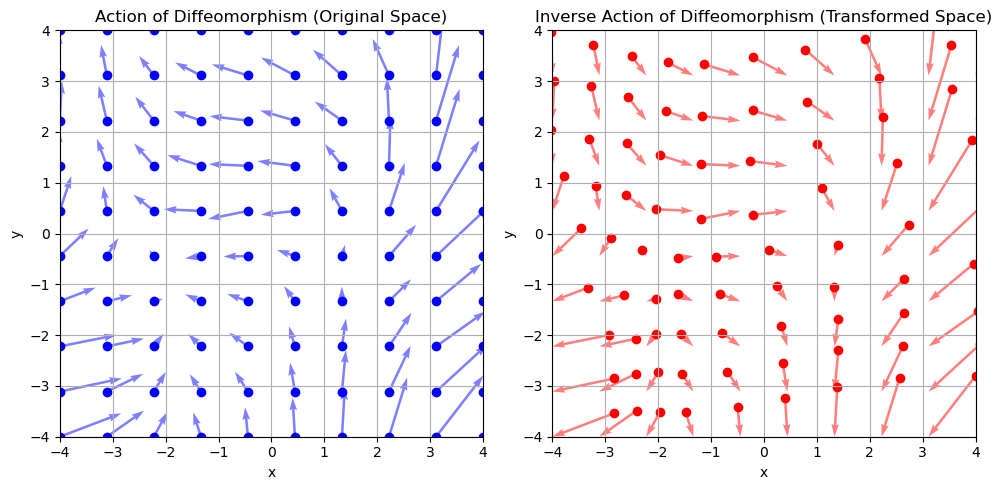

In [130]:
# Visualize the action of the diffeomorphism
epsilon=.3
dim=2
num_samples=10
grid_points=True
set_seed(2)
diffeomorphism_network, original_samples, transformed_samples = generate_random_diffeomorphism(dim, num_samples, epsilon, grid_points, bounds, activation='relu')

plot_diffeomorphism_action(original_samples, transformed_samples, bounds)

In [ ]:
t_values, lc_trajectories, initial_conditions = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt,                           # Time step
    num_points=num_points,                     # Number of initial points to sample
    kernel_fn=kernel_with_sigma,       # The kernel function for density-based sampling
    system=LimitCycle()           # The target system
)

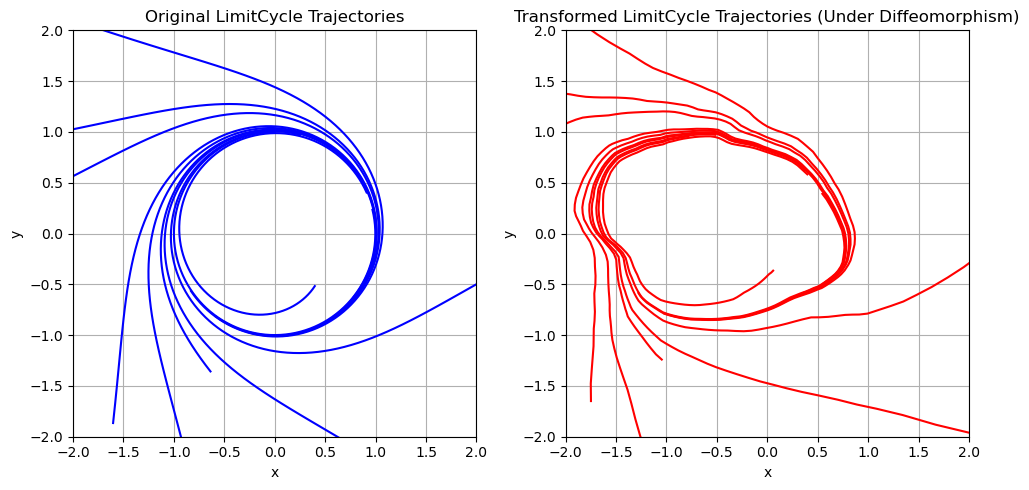

In [132]:
# Apply diffeomorphism to the trajectories
transformed_trajectories = []
for trajectory in lc_trajectories:
    transformed_trajectory = apply_diffeomorphism_to_trajectory(diffeomorphism_network, trajectory)
    transformed_trajectories.append(transformed_trajectory)

# Plot the original and transformed trajectories
plot_trajectories_comparison(lc_trajectories, transformed_trajectories, num_points=10)

In [251]:
limit_cycle_system = LimitCycle()
transformed_system = TransformedSystem(limit_cycle_system, diffeomorphism_network)

t_values, diff_trajectories, initial_conditions = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt,                           # Time step
    num_points=num_points,                     # Number of initial points to sample
    kernel_fn=kernel_with_sigma,       # The kernel function for density-based sampling
    system=transformed_system           # The target system, e.g., VanDerPol system
)

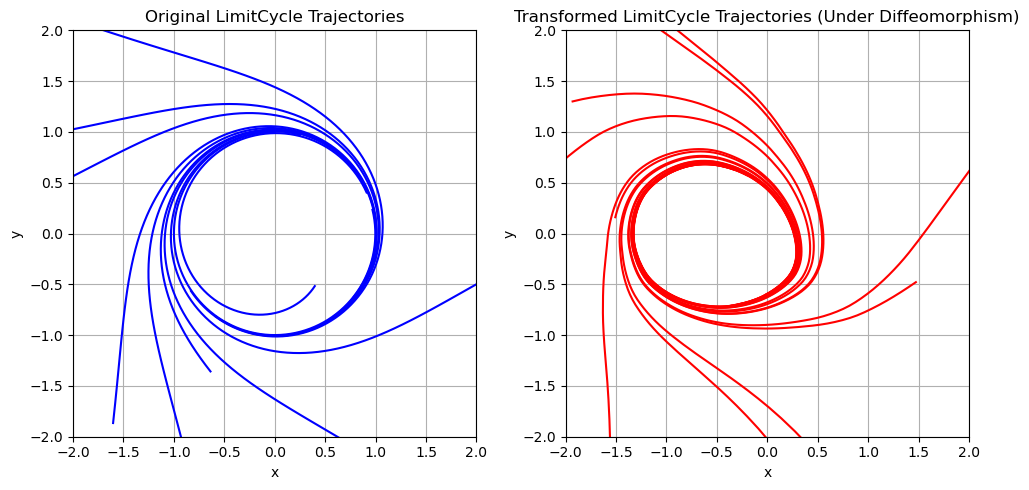

In [249]:
plot_trajectories_comparison(lc_trajectories, diff_trajectories, num_points=10)


# Fitting a diffeomorphism

In [240]:
np.random.seed(42)
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt,                           # Time step
    num_points=num_points,                     # Number of initial points to sample
    kernel_fn=kernel_with_sigma,       # The kernel function for density-based sampling
    system=transformed_system           # The target system, e.g., VanDerPol system
)

In [241]:
source_system_ra = RingAttractor()
A = torch.tensor([[0.0, -1.0], [1.0, 0.0]], dtype=torch.float32)   #center manifold/harmoinc oscillator
A = torch.tensor([[-1.0, 0.0], [0.0, -1.0]], dtype=torch.float32)  #stable node
source_system_linear = LinearSystem(A)
motif_library = [limit_cycle_system, source_system_ra, source_system_linear]
diffeo_net = DiffeomorphismNetwork(dim=2)
diffeo_ra = DiffeomorphismNetwork(dim=2)
diffeo_net_linear = DiffeomorphismNetwork(dim=2)
diffeo_networks = [diffeo_net, diffeo_ra, diffeo_net_linear]
diffeo_networks = train_all_motifs(motif_library, diffeo_networks, trajectories_target, initial_conditions_target, time_span=time_span, dt=dt,
                                   lr=0.001, num_epochs=100)

Training diffeomorphism for motif: LimitCycle


C:\Users\abel_\AppData\Local\Temp\ipykernel_19572\3285323274.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


Epoch 0, Loss: 0.7144
Epoch 10, Loss: 0.1237
Epoch 20, Loss: 0.0298
Epoch 30, Loss: 0.0444
Epoch 40, Loss: 0.0246
Epoch 50, Loss: 0.0241
Epoch 60, Loss: 0.0217
Epoch 70, Loss: 0.0206
Epoch 80, Loss: 0.0198
Epoch 90, Loss: 0.0188
Total training time: 114.00 seconds, Avg time per epoch: 1.1400 sec
Training diffeomorphism for motif: RingAttractor
Epoch 0, Loss: 0.6916
Epoch 10, Loss: 0.4422
Epoch 20, Loss: 0.4428
Epoch 30, Loss: 0.4172
Epoch 40, Loss: 0.4055
Epoch 50, Loss: 0.3923
Epoch 60, Loss: 0.3802
Epoch 70, Loss: 0.3697
Epoch 80, Loss: 0.3605
Epoch 90, Loss: 0.3532
Total training time: 93.18 seconds, Avg time per epoch: 0.9318 sec
Training diffeomorphism for motif: LinearSystem
Epoch 0, Loss: 0.7257
Epoch 10, Loss: 0.3907
Epoch 20, Loss: 0.3665
Epoch 30, Loss: 0.3473
Epoch 40, Loss: 0.3284
Epoch 50, Loss: 0.3131
Epoch 60, Loss: 0.2987
Epoch 70, Loss: 0.2854
Epoch 80, Loss: 0.2750
Epoch 90, Loss: 0.2659
Total training time: 39.28 seconds, Avg time per epoch: 0.3928 sec


C:\Users\abel_\AppData\Local\Temp\ipykernel_19572\105055424.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


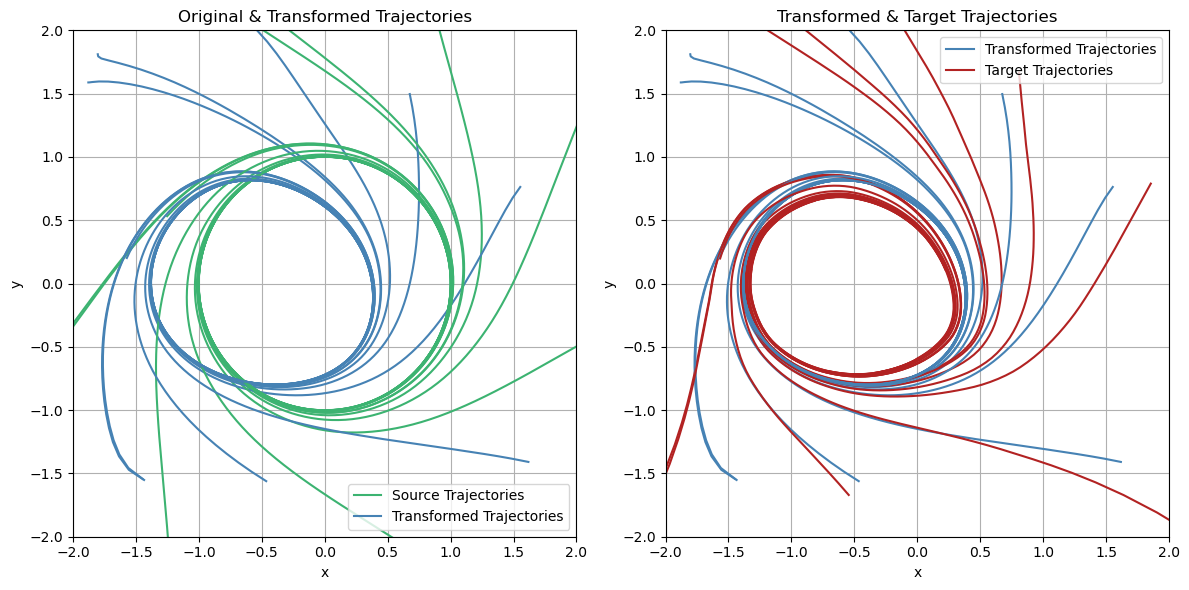

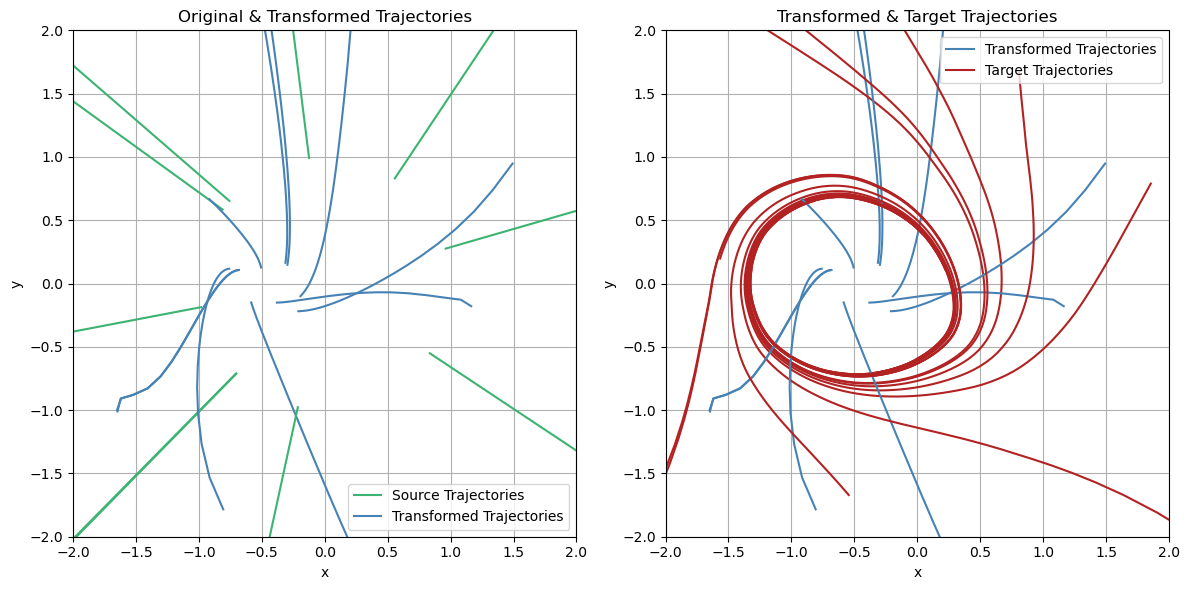

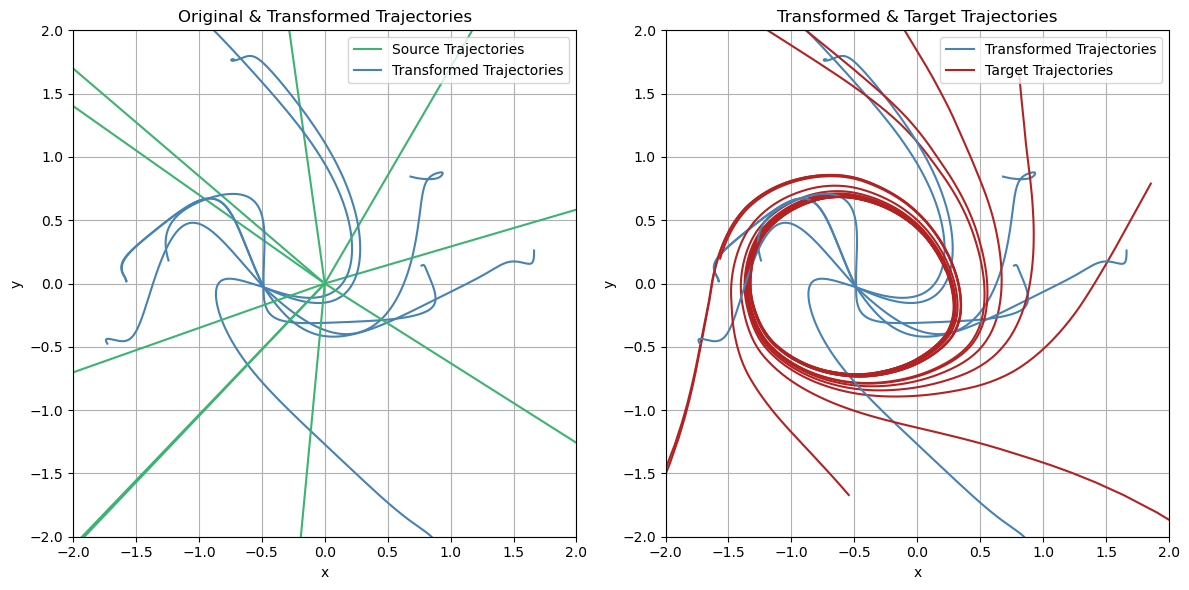

In [ ]:
initial_conditions = np.array([trajectories_target[i][0].detach().numpy() for i in range(num_points)])
initial_conditions = torch.tensor(initial_conditions, dtype=torch.float32)

for motif, diffeo_net in zip(motif_library, diffeo_networks):
    initial_conditions = diffeo_net.inverse(initial_conditions)
    t_values, trajectories_source, _ = generate_trajectories_scipy(
        sampling_method='random', bounds=(1.0, 1.0), time_span=time_span,
        dt=dt, num_points=num_points, system=motif,
        predefined_initial_conditions=initial_conditions  # Use numpy to avoid gradients
    )
    transformed_trajectories = [diffeo_net(traj.requires_grad_()) for traj in trajectories_source]
    plot_trajectories_stt(trajectories_source, transformed_trajectories, trajectories_target, bounds=(2.0, 2.0),
     color_source='mediumseagreen', color_transformed='steelblue', color_target='firebrick' ) #mediumseagreen/teal?

# Fitting a the Vanderpol system

In [242]:
# generate trajectories for the target system
np.random.seed(42)
vdp_system = VanDerPol(mu=.4)
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)

In [243]:
diffeo_net = DiffeomorphismNetwork(dim=2)
diffeo_ra = DiffeomorphismNetwork(dim=2)
diffeo_net_linear = DiffeomorphismNetwork(dim=2)
diffeo_networks = [diffeo_net, diffeo_ra, diffeo_net_linear]
diffeo_networks = train_all_motifs(motif_library, diffeo_networks, trajectories_target, initial_conditions_target, time_span=time_span, dt=dt,
                                   lr=0.001, num_epochs=200)

Training diffeomorphism for motif: LimitCycle


C:\Users\abel_\AppData\Local\Temp\ipykernel_19572\3285323274.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


Epoch 0, Loss: 2.4032
Epoch 10, Loss: 1.2880
Epoch 20, Loss: 0.6587
Epoch 30, Loss: 0.4569
Epoch 40, Loss: 0.8496
Epoch 50, Loss: 1.6075
Epoch 60, Loss: 0.5674
Epoch 70, Loss: 0.4252
Epoch 80, Loss: 0.4323
Epoch 90, Loss: 0.4518
Epoch 100, Loss: 0.4404
Epoch 110, Loss: 0.4390
Epoch 120, Loss: 0.4473
Epoch 130, Loss: 0.4522
Epoch 140, Loss: 0.4505
Epoch 150, Loss: 0.4534
Epoch 160, Loss: 0.4606
Epoch 170, Loss: 0.4649
Epoch 180, Loss: 0.4692
Epoch 190, Loss: 0.4755
Total training time: 209.12 seconds, Avg time per epoch: 1.0456 sec
Training diffeomorphism for motif: RingAttractor
Epoch 0, Loss: 2.3748
Epoch 10, Loss: 2.1982
Epoch 20, Loss: 2.1835
Epoch 30, Loss: 2.1605
Epoch 40, Loss: 2.1454
Epoch 50, Loss: 2.1263
Epoch 60, Loss: 2.1073
Epoch 70, Loss: 2.0865
Epoch 80, Loss: 2.0663
Epoch 90, Loss: 2.0470
Epoch 100, Loss: 2.0306
Epoch 110, Loss: 2.0169
Epoch 120, Loss: 2.0055
Epoch 130, Loss: 1.9964
Epoch 140, Loss: 1.9886
Epoch 150, Loss: 1.9806
Epoch 160, Loss: 1.9710
Epoch 170, Loss: 

C:\Users\abel_\AppData\Local\Temp\ipykernel_19572\3285323274.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


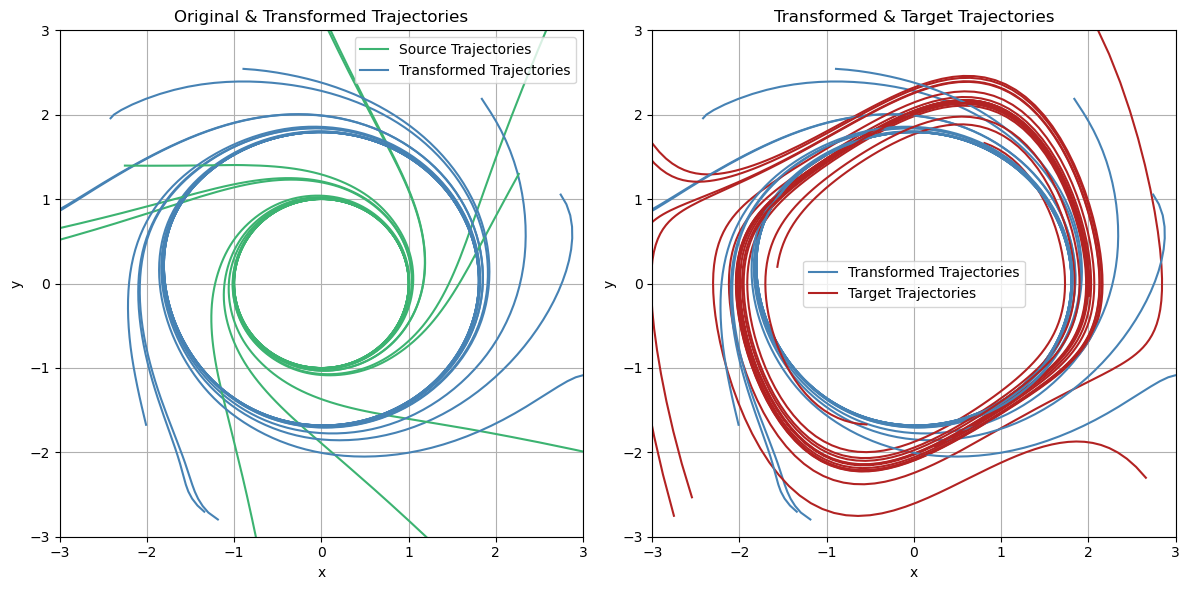

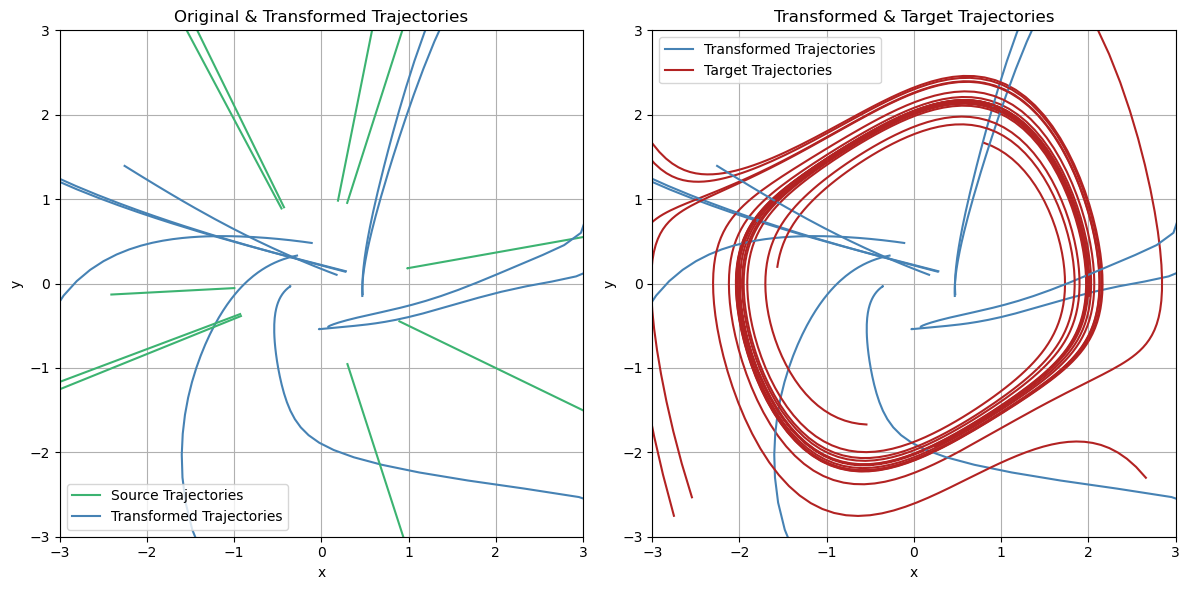

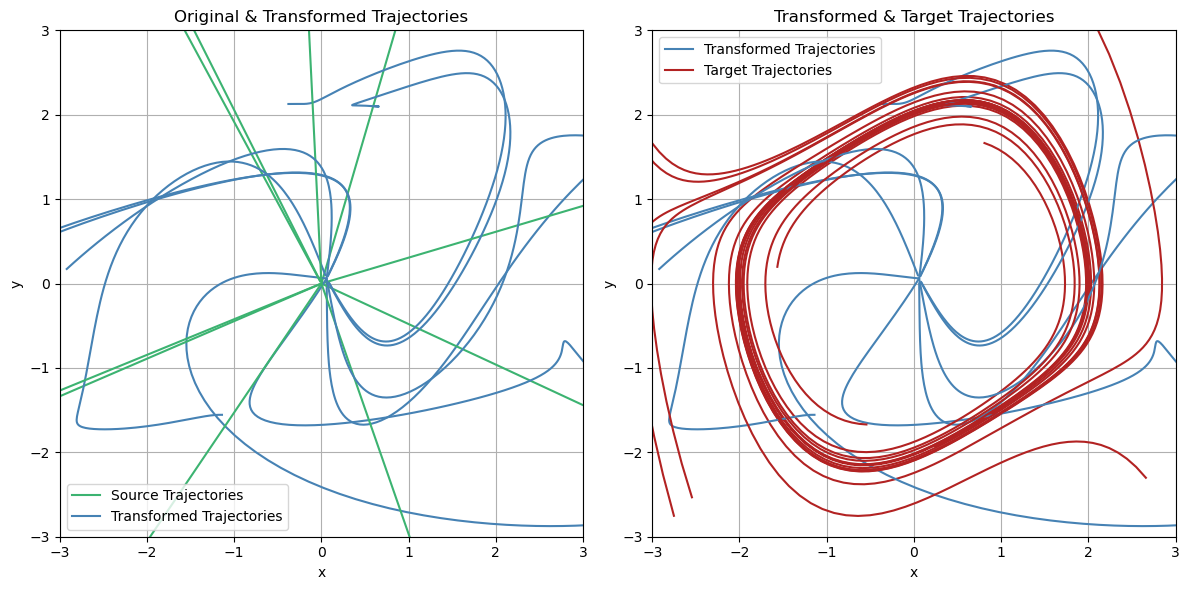

In [244]:
initial_conditions = np.array([trajectories_target[i][0].detach().numpy() for i in range(num_points)])
initial_conditions = torch.tensor(initial_conditions, dtype=torch.float32)

for motif, diffeo_net in zip(motif_library, diffeo_networks):
    initial_conditions = diffeo_net.inverse(initial_conditions)
    t_values, trajectories_source, _ = generate_trajectories_scipy(
        sampling_method='random', bounds=(1.0, 1.0), time_span=time_span,
        dt=dt, num_points=num_points, system=motif,
        predefined_initial_conditions=initial_conditions  # Use numpy to avoid gradients
    )
    transformed_trajectories = [diffeo_net(traj.requires_grad_()) for traj in trajectories_source]
    plot_trajectories_stt(trajectories_source, transformed_trajectories, trajectories_target, bounds=(3.0, 3.0),
     color_source='mediumseagreen', color_transformed='steelblue', color_target='firebrick' ) #mediumseagreen/teal?

# Fitting a diffeo with transformed vector field

In [254]:
limit_cycle_system = LimitCycle()
transformed_system = TransformedSystem(limit_cycle_system, diffeomorphism_network)

t_values, diff_trajectories, initial_conditions = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt,                           # Time step
    num_points=num_points,                     # Number of initial points to sample
    kernel_fn=kernel_with_sigma,       # The kernel function for density-based sampling
    system=transformed_system           # The target system, e.g., VanDerPol system
)

In [ ]:
diffeo_net = DiffeomorphismNetwork(dim=2)
diffeo_ra = DiffeomorphismNetwork(dim=2)
diffeo_net_linear = DiffeomorphismNetwork(dim=2)
diffeo_networks = [diffeo_net, diffeo_ra, diffeo_net_linear]
diffeo_networks = train_all_motifs(motif_library, diffeo_networks, trajectories_target, initial_conditions_target, time_span=time_span, dt=dt,
                                   lr=0.001, num_epochs=100, use_transformed_system=True)

Training diffeomorphism for motif: LimitCycle


C:\Users\abel_\AppData\Local\Temp\ipykernel_19572\782587281.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


Epoch 0, Loss: 188.2822
Epoch 10, Loss: 41.5950
Epoch 20, Loss: 14.0417
